Import library and crawling robot simulator

In [32]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pygame
from robot_simulation import CrawlingRobotSimulator
from IPython.display import display, clear_output

import cv2
def create_video_from_frames(frames, output_filename, fps=2, fourcc_codec='mp4v'):
    if not frames:
        raise ValueError("The frame list is empty.")
    
    frame_size = frames[0].shape[1], frames[0].shape[0]
    fourcc = cv2.VideoWriter_fourcc(*fourcc_codec)
    
    out = cv2.VideoWriter(output_filename, fourcc, fps, frame_size)
    
    for frame in frames:
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        out.write(frame_rgb)
    out.release()

First we define the environment.
<br>
<br>
This `CrawlingRobotEnvironment` seem scary the logic is quite simple.
It boils down to:
1. Initialize: This is the trickiest part.
    - We have `self.eps` as the floating error threshold
    - simulator is the `CrawlingRobotSimulator` defined using pymunk.
    - state_bins need to be list of 2 numpy arrays, representing arm's angle and hand's angle.
    - there are 4 possible actions for rotating arm and hand.   
2. function that reset the game.
3. function that take in `action` and the robot perform that action.
4. render the grapfic.

In [33]:
class CrawlingRobotEnvironment:
    def __init__(self, simulator: CrawlingRobotSimulator, goal_x: int, state_bins: list):
        self.eps = 0.01
        self.sim = simulator
        self.state_bins = state_bins
        self.possible_actions = [0, 1, 2, 3] # 4 actions are rotating 1) hand cw, 2) hand ccw, 3) arm cw, 4) arm ccw.
                                             # where cw is clockwise rotation and ccw is counter clockwise rotation.
        self.num_actions = len(self.possible_actions)
        self.num_states = self.state_bins[0].shape + self.state_bins[1].shape
        self.goal_x = goal_x
        
    def reset(self):
        # reset the environment... the robot's position, arm's angle, and hand's angle.  
        self.sim.reset_bodies(self.sim.bodyXY)
        _, handAngle, armAngle = self.sim.get_states()
        return handAngle, armAngle
    
    def step(self, action, render=False):
        for event in pygame.event.get(): # Quit the game if get quit_signal.
            if event.type == pygame.QUIT:
                pygame.quit()
                
        done = False
        x_old, _, _ = self.sim.get_states()
        motor_hand = self.sim.motor_hand
        motor_arm = self.sim.motor_arm
        
        # handle actions... there are 4 possible actions 1) hand cw, 2) hand ccw, 3) arm cw, 4) arm ccw.
        if action == 0: # rotate hand's motor clockwise
            new_angle = motor_hand.angle() + np.deg2rad(20)
            motor_hand.set_target_angle(new_angle)
        elif action == 1: # rotate hand's motor counter-clockwise
            new_angle = motor_hand.angle() - np.deg2rad(20)
            motor_hand.set_target_angle(new_angle)
        elif action == 2: # rotate arm's motor clockwise
            new_angle = motor_arm.angle() - np.deg2rad(10)
            motor_arm.set_target_angle(new_angle)
        elif action == 3: # rotate arm's motor counter-clockwise
            new_angle = motor_arm.angle() + np.deg2rad(10)
            motor_arm.set_target_angle(new_angle)
        else: 
            # Do not move if no input is given, this is not used in this version.
            # We decided to leave it here, for anyone wanting to experiment with this.
            motor_hand.rate = 0
            motor_arm.rate = 0
            
        while True:
            # Rotating the arm and hand to the target angles takes continuous time, while Q-learning works in discrete time steps.
            # This loop waits until the hand and arm have reached their target angles before proceeding.
            for motor in self.sim.motor_list:
                motor.update()
            self.sim.update_simulation()
            if render:
                self.render()
            _, handAngle, armAngle = self.sim.get_states()
            if abs(handAngle - motor_hand.target_angle) < self.eps and abs(armAngle - motor_arm.target_angle) < self.eps:
                break


        # Calculate the reward and next state.
        x, handAngle, armAngle = self.sim.get_states()
        next_state = (handAngle, armAngle)        
        reward = x - x_old

        if x < -20: # If the robot goes out of bound.
            done = True
        elif x > self.goal_x: # If the robot reach the goal position.
            done = True
        return next_state, reward, done
    
    def render(self):
        self.sim.draw()

In [34]:
class QAgent:
    def __init__(
        self, 
        env: CrawlingRobotEnvironment,
        num_episodes: int,
        learning_rate: float,
        discount_factor: float,
        epsilon: float,
        min_epsilon: float,
        epsilon_decay: float
    ):
        self.num_episodes = num_episodes
        self.learning_rate = learning_rate
        self.discount_factor =discount_factor
        self.epsilon = epsilon
        self.min_epsilon = min_epsilon
        self.epsilon_decay = epsilon_decay
        self.possible_actions = env.possible_actions
        self.state_bins = env.state_bins
        self.Qtable = np.zeros(env.num_states + (env.num_actions, )) # initialze Q-table as all zeros.
    
    def select_action(self, state, greedy=False):
        """Epsilon greedy policy."""
        eps = self.epsilon 
        if greedy: eps = 0
        if np.random.rand() < eps: # take random action
            action = np.random.choice(self.possible_actions)
        else: # take best action from Q-table
            state_index = self.discretize_state(state)
            action = self.possible_actions[np.argmax(self.Qtable[state_index])]
        return action

    def update_q_value(self, state, action, reward, next_state):
        """The Q-value update equation."""
        state_index = self.discretize_state(state)
        next_state_index = self.discretize_state(next_state)
        action_index = self.possible_actions.index(action)
        future_reward = np.max(self.Qtable[next_state_index])
        current_q = self.Qtable[state_index][action_index]
        self.Qtable[state_index][action_index] = current_q + self.learning_rate * (reward + self.discount_factor * future_reward - current_q)
        
    def discretize_state(self, state, hysteresis_margin=0.05):
        """Discretize state."""
        arm_value = state[0]
        hand_value = state[1]
        arm_idx = np.digitize(arm_value, [x - hysteresis_margin for x in self.state_bins[0]]) - 1
        hand_idx = np.digitize(hand_value, [x - hysteresis_margin for x in self.state_bins[1]]) - 1
        return arm_idx, hand_idx

    def decay_epsilon(self):
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)    

In [35]:
def train(fric: float,
          num_episodes: int,
          learning_rate: float,
          discount_factor: float,
          epsilon: float,
          min_epsilon: float,
          epsilon_decay: float):
    # Initialize crawling robot simulator
    sim = CrawlingRobotSimulator()
    sim.init()
    sim.body_shape.friction = fric

    # Initialize agent and environment
    state_bins = [
        np.linspace(sim.min_hand_angle, sim.max_hand_angle, 10),
        np.linspace(sim.min_arm_angle, sim.max_arm_angle, 10),
    ]
    
    env = CrawlingRobotEnvironment(sim, goal_x=400, state_bins=state_bins) 
    agent = QAgent(env=env, 
                   num_episodes=num_episodes,
                   learning_rate=learning_rate,
                   discount_factor=discount_factor,
                   epsilon=epsilon,
                   min_epsilon=min_epsilon,
                   epsilon_decay=epsilon_decay
                  )

    # Initialize plotting
    n_reward_plots_per_action = 50
    plt.ion()
    fig, ax = plt.subplots(2, 1)
    ax[0].set_xlabel('Episode')
    ax[0].set_ylabel('Reward')
    ax[0].set_title('Reward per Episode')
    line_episode, = ax[0].plot([], [], label='Total Episode Reward')
    ax[0].legend()
    
    ax[1].set_xlabel(f'{n_reward_plots_per_action} actions')
    ax[1].set_ylabel('Reward')
    ax[1].set_title(f'Reward per {n_reward_plots_per_action} actions')
    line, = ax[1].plot([], [], label=f'Rewards per {n_reward_plots_per_action} actions')
    ax[1].legend()
    plt.suptitle(f'friction={fric}')
    
    rewards = []
    episode_rewards = []

    try:
        for episode in range(1, agent.num_episodes + 1):
            state = env.reset()
            done = False
            episode_reward = 0
            counter = 0
            while not done:
                action = agent.select_action(state)
                new_state, reward, done = env.step(action, render=False)
                agent.update_q_value(state, action, reward, new_state)
                state = new_state
                episode_reward += reward

                # Save reward every {n_reward_plots_per_action} actions for plotting figures.
                if counter % n_reward_plots_per_action == 0:  
                    rewards.append(reward)
                counter += 1

            episode_rewards.append(episode_reward)
            agent.decay_epsilon()

            # Update plot
            line.set_xdata(np.arange(len(rewards)))
            line.set_ydata(rewards)
            line_episode.set_xdata(range(len(episode_rewards)))
            line_episode.set_ydata(episode_rewards)
            ax[0].relim()
            ax[0].autoscale_view()
            ax[1].relim()
            ax[1].autoscale_view()
            clear_output(wait=True)
            display(fig)
            plt.tight_layout()
            plt.pause(0.01)

    finally:
        pygame.quit()
        plt.ioff()
        
    return agent

In [36]:
def record(agent, fric, max_steps=1000):
    """Record and return the frames of robot crawling forward."""
    frames = []

    sim = CrawlingRobotSimulator()
    sim.init()
    sim.body_shape.friction = fric
        
    env = CrawlingRobotEnvironment(sim, goal_x=400, state_bins=agent.state_bins)
    state = env.reset()
    done = False

    # Initialize plotting
    plt.ion()
    fig, ax = plt.subplots(1, 1)
    ax.set_xlabel('Episode')
    ax.set_ylabel('Reward')
    ax.set_title('Reward per action')
    line, = ax.plot([], [], label='Reward per action')
    ax.legend()
    plt.suptitle(f'friction={fric}')

    rewards = []
    
    while not done:
        if len(frames) > max_steps:
            break
        action = agent.select_action(state, greedy=True)
        new_state, reward, done = env.step(action, render=True)
        state = new_state

        # Update the reward plot.
        rewards.append(reward)
        line.set_xdata(np.arange(len(rewards)))
        line.set_ydata(rewards) 
        line.set_ydata(rewards)
        ax.relim()
        ax.autoscale_view()
        clear_output(wait=True)
        display(fig)
        plt.tight_layout()
        plt.pause(0.01)
        
        # Capture the current frame
        frame_shape = (env.sim.display_size[1], env.sim.display_size[0], 3)
        raw_data = pygame.image.tostring(env.sim.screen, "RGB")
        img = np.frombuffer(raw_data, dtype=np.uint8)
        img = img.reshape(frame_shape)
        frames.append(img)
    return frames

In [38]:
if not os.path.exists('animate'):
    os.mkdir('animate')
    
num_episodes = 20
learning_rate = 0.1
discount_factor = 0.99
epsilon = 1
min_epsilon = 0.1
epsilon_decay = 0.9
robot_frictions = [0.05, 0.5] # two level of frictions.

We also include reward per episode and per 50 actions here.

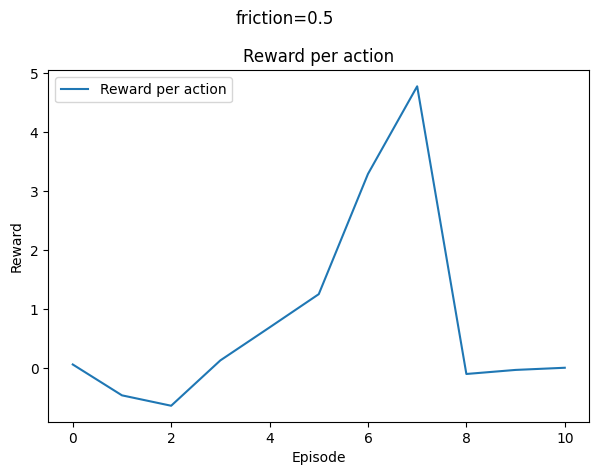

<Figure size 640x480 with 0 Axes>

In [39]:
for fric in robot_frictions: # Train and animate the crawling robot with different level of frictions.
    file_name = f'animate/crawlingRobot_fric{fric}.mp4' # save the animation of the final robot to this file.
    agent = train(fric, num_episodes, learning_rate, discount_factor, epsilon, min_epsilon, epsilon_decay)
    try: 
        frames = record(agent, fric, max_steps=1000) # set max_step in case robot do not converge.
    finally:
        create_video_from_frames(frames, file_name, fps=16)
        pygame.quit()

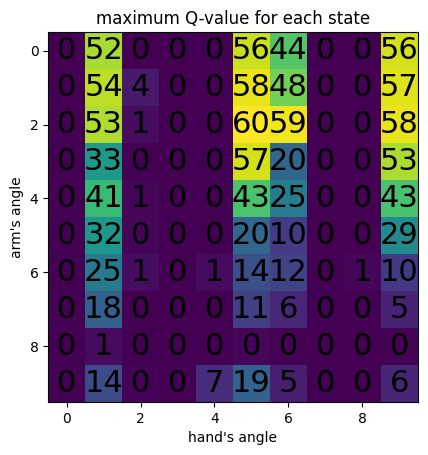

In [40]:
to_plot = agent.Qtable.max(axis=2)
plt.title('maximum Q-value for each state')
plt.imshow(to_plot)
for (r_idx, row) in enumerate(to_plot):
    for (c_idx, val) in enumerate(row):
            plt.text(c_idx, r_idx, f'{int(val):.0f}', ha='center', va='center', color='black', fontsize=22)
plt.xlabel('hand\'s angle')
plt.ylabel('arm\'s angle')
plt.show()

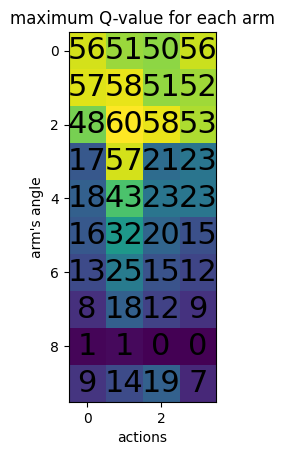

In [41]:
to_plot = agent.Qtable.max(axis=1)
plt.title('maximum Q-value for each arm')
plt.imshow(to_plot)
for (r_idx, row) in enumerate(to_plot):
    for (c_idx, val) in enumerate(row):
        plt.text(c_idx, r_idx, f'{int(val):.0f}', ha='center', va='center', color='black', fontsize=22)
plt.xlabel('actions')
plt.ylabel('arm\'s angle')
plt.show()

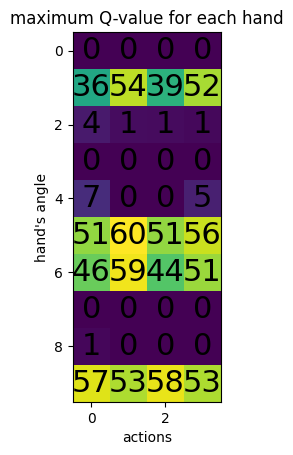

In [42]:
to_plot = agent.Qtable.max(axis=0)
plt.title('maximum Q-value for each hand')
plt.imshow(to_plot)
for (r_idx, row) in enumerate(to_plot):
    for (c_idx, val) in enumerate(row):
        plt.text(c_idx, r_idx, f'{int(val):.0f}', ha='center', va='center', color='black', fontsize=22)
plt.xlabel('actions')
plt.ylabel('hand\'s angle')
plt.show()